# Application du modèle économétrique

Nous allons appliquer notre modèle translog aux différentes variables construites précédemment. 


In [97]:
import os 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm

## 1. Construction de la base nécessaire à l'application du modèle

On crée une base contenant la variable d'intérêt Y (les points ISA), les variables explicatives et les variables de contrôle.

In [98]:
VAR_EXPL = pd.read_csv('C:/Users/mille/OneDrive/Documents/ENSAE/2ème année/Stat App/VAR_EXPL.csv')
VAR_EXPL_SPL = pd.read_csv('C:/Users/mille/OneDrive/Documents/ENSAE/2ème année/Stat App/VAR_EXPL_SPL.csv')
VAR_CTRL = pd.read_excel('C:/Users/mille/OneDrive/Documents/ENSAE/2ème année/Stat App/VAR_CTRL.xlsx')
VAR_CTRL

,Unnamed: 0,Numero_finess,Points_ISA,stjr,dep,COMINSEE,LIT_MCO,Capital_Bloc,Capital_imagerie,Capital_Examens_biologiques,...,Taux_chomage_par_dep,Bloc_politique,Q1_A,Q1_B,Q1_C,Q1_D,Q8_A,Q8_B,Q8_C,Q8_D
0,0,060000528,356892.030000,3,06,06088,128.0,8.0,9.0,909.0,...,8.9,Centre droit à droite,70.000000,30.000000,NaN,NaN,33.333333,28.571429,38.095238,NaN
1,1,060780947,174552.540000,3,06,06088,105.0,5.0,4.0,0.0,...,8.9,Centre droit à droite,14.545455,38.181818,32.727273,14.545455,19.852941,21.323529,58.823529,NaN
2,2,060791811,146432.633333,3,06,06088,91.0,2.0,2.0,0.0,...,8.9,Centre droit à droite,14.545455,38.181818,32.727273,14.545455,19.852941,21.323529,58.823529,NaN
3,3,060780442,22842.380000,2,06,06088,30.0,6.0,1.0,0.0,...,8.9,Centre droit à droite,18.478261,41.304348,30.434783,9.782609,42.766296,19.236884,37.996820,NaN
4,4,060780715,342051.171667,2,06,06088,256.0,26.0,10.0,0.0,...,8.9,Centre droit à droite,18.478261,41.304348,30.434783,9.782609,42.766296,19.236884,37.996820,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1190,469,570000141,7607.485000,1,57,57631,24.0,0.0,0.0,0.0,...,8.2,Droite à extrême droite,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1191,637,640019220,75597.775000,2,64,64445,137.0,19.0,0.0,0.0,...,7.0,Centre gauche à centre droit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1192,640,640780862,413.120000,1,64,64445,0.0,0.0,0.0,0.0,...,7.0,Centre gauche à centre droit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1193,906,670020098,9344.040000,3,67,67482,120.0,3.0,0.0,0.0,...,7.1,Centre gauche à centre droit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
del VAR_EXPL['Unnamed: 0']
del VAR_EXPL_SPL['Unnamed: 0']
del VAR_CTRL['Unnamed: 0']


KeyError: 'Unnamed: 0'

In [102]:
VAR_EXPL.columns

Index(['Numero_finess', 'Médecins libéraux',
       'Autres personnels médicaux libéraux', 'Médecins salariés',
       'Autres personnels médicaux salariés',
       'Personnels de direction et administratifs',
       'Personnels des services de soins', 'Personnels éducatifs et sociaux',
       'Personnels médico-techniques', 'Personnels techniques et ouvriers',
       'Points_ISA', 'stjr', 'Internes'],
      dtype='object')

In [104]:
df = pd.merge(VAR_EXPL, VAR_CTRL, on = ['Numero_finess'])
df.columns

Index(['Numero_finess', 'Médecins libéraux',
       'Autres personnels médicaux libéraux', 'Médecins salariés',
       'Autres personnels médicaux salariés',
       'Personnels de direction et administratifs',
       'Personnels des services de soins', 'Personnels éducatifs et sociaux',
       'Personnels médico-techniques', 'Personnels techniques et ouvriers',
       'Points_ISA_x', 'stjr_x', 'Internes', 'Points_ISA_y', 'stjr_y', 'dep',
       'COMINSEE', 'LIT_MCO', 'Capital_Bloc', 'Capital_imagerie',
       'Capital_Examens_biologiques', 'Capital_telemed', 'SEJHC_MED',
       'SEJHC_CHI', 'SEJHC_OBS', 'SEJHC_MCO', 'JOU_MED', 'JOU_CHI', 'JOU_OBS',
       'JOU_MCO', 'Departement', 'Taux_chomage_par_dep', 'Bloc_politique',
       'Q1_A', 'Q1_B', 'Q1_C', 'Q1_D', 'Q8_A', 'Q8_B', 'Q8_C', 'Q8_D'],
      dtype='object')

In [88]:
df = pd.merge(df, VAR_EXPL_SPL)
df

,Numero_finess,Médecins libéraux,Autres personnels médicaux libéraux,Médecins salariés,Autres personnels médicaux salariés,Personnels de direction et administratifs,Personnels des services de soins,Personnels éducatifs et sociaux,Personnels médico-techniques,Personnels techniques et ouvriers,...,Q1_C,Q1_D,Q8_A,Q8_B,Q8_C,Q8_D,Personnel médical,Autre sans internes,Autre sans direction et administratif,Autre sans techniques et ouvriers
0,010007300,4.5,3.0,0.000,0.000,2.250,4.200,NaN,NaN,NaN,...,30.434783,9.782609,42.766296,19.236884,37.996820,NaN,7.500,NaN,NaN,NaN
1,010009132,0.0,0.0,1.795,0.070,4.175,46.700,1.065,1.13,13.465,...,48.309179,33.816425,6.018519,10.339506,83.641975,NaN,1.865,19.835,15.660,6.370
2,010780054,4.5,1.0,102.600,44.530,118.605,388.590,4.930,107.66,112.630,...,48.309179,33.816425,6.018519,10.339506,83.641975,NaN,152.630,343.825,420.310,426.285
3,010780096,0.0,0.0,10.260,1.885,9.685,88.475,2.555,2.57,5.960,...,48.309179,33.816425,6.018519,10.339506,83.641975,NaN,12.145,20.770,14.565,18.290
4,010780203,8.5,13.0,1.880,1.810,35.360,143.730,NaN,4.20,6.120,...,30.434783,9.782609,42.766296,19.236884,37.996820,NaN,25.190,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,950110049,0.0,0.0,123.710,108.600,230.040,1540.470,39.790,99.35,318.480,...,48.309179,33.816425,6.018519,10.339506,83.641975,NaN,232.310,687.660,738.270,649.830
795,950300095,10.0,8.0,0.000,1.000,20.170,74.980,NaN,1.00,3.000,...,30.434783,9.782609,42.766296,19.236884,37.996820,NaN,19.000,NaN,NaN,NaN
796,950300301,2.0,0.5,6.970,1.800,22.560,103.560,1.380,2.94,3.000,...,30.434783,9.782609,42.766296,19.236884,37.996820,NaN,11.270,29.880,7.320,26.880
797,950300350,5.5,6.5,1.000,0.800,6.600,27.550,NaN,3.00,1.000,...,30.434783,9.782609,42.766296,19.236884,37.996820,NaN,13.800,NaN,NaN,NaN


On obtient bien 1155 établissements, le nombre d'établissements qui avaient des données dans les bases du personnel. On n'a donc pas pris en compte les établissements présents dans la base des variables explicatives mais dont on ne pouvait rien dire, faute de données sur leur personnel.  

In [49]:
df.columns

Index(['Numero_finess', 'Médecins libéraux',
       'Autres personnels médicaux libéraux', 'Médecins salariés',
       'Autres personnels médicaux salariés',
       'Personnels de direction et administratifs',
       'Personnels des services de soins', 'Personnels éducatifs et sociaux',
       'Personnels médico-techniques', 'Personnels techniques et ouvriers',
       'Points_ISA', 'stjr', 'Internes', 'dep', 'COMINSEE', 'LIT_MCO',
       'Capital_Bloc', 'Capital_imagerie', 'Capital_Examens_biologiques',
       'Capital_telemed', 'SEJHC_MED', 'SEJHC_CHI', 'SEJHC_OBS', 'SEJHC_MCO',
       'JOU_MED', 'JOU_CHI', 'JOU_OBS', 'JOU_MCO', 'Departement',
       'Taux_chomage_par_dep', 'Bloc_politique', 'Q1_A', 'Q1_B', 'Q1_C',
       'Q1_D', 'Q8_A', 'Q8_B', 'Q8_C', 'Q8_D'],
      dtype='object')

On construit des variables plus générales pour nos premières analyses : on regroupe les différentes mesures des ressources techniques des hôpitaux dans la variable Capital_Tech et les différents types de personnels libéraux et salariés dans les mêmes catégorie.

In [50]:
df = df.assign(Capital_tech = df['Capital_Bloc'] + df['Capital_imagerie'] + df['Capital_Examens_biologiques'] 
               + df['Capital_telemed'], 
              Médecins = df['Médecins libéraux'] + df['Médecins salariés'],
              Autres_personnels_médicaux = df['Autres personnels médicaux libéraux'] +df['Autres personnels médicaux salariés'])
df

,Numero_finess,Médecins libéraux,Autres personnels médicaux libéraux,Médecins salariés,Autres personnels médicaux salariés,Personnels de direction et administratifs,Personnels des services de soins,Personnels éducatifs et sociaux,Personnels médico-techniques,Personnels techniques et ouvriers,...,Q1_B,Q1_C,Q1_D,Q8_A,Q8_B,Q8_C,Q8_D,Capital_tech,Médecins,Autres_personnels_médicaux
0,010007300,4.5,3.0,0.000,0.00,2.250000,4.200000,NaN,NaN,NaN,...,41.304348,30.434783,9.782609,42.766296,19.236884,37.996820,NaN,1.0,4.500,3.00
1,010008407,0.0,0.0,18.490,14.33,21.196667,97.323333,0.846667,9.206667,26.440,...,14.975845,48.309179,33.816425,6.018519,10.339506,83.641975,NaN,265754.0,18.490,14.33
2,010009132,0.0,0.0,1.795,0.07,4.175000,46.700000,1.065000,1.130000,13.465,...,14.975845,48.309179,33.816425,6.018519,10.339506,83.641975,NaN,0.0,1.795,0.07
3,010780054,4.5,1.0,102.600,44.53,118.605000,388.590000,4.930000,107.660000,112.630,...,14.975845,48.309179,33.816425,6.018519,10.339506,83.641975,NaN,954720.0,107.100,45.53
4,010780062,0.0,0.0,19.450,10.10,58.450000,336.540000,5.450000,29.320000,57.570,...,14.975845,48.309179,33.816425,6.018519,10.339506,83.641975,NaN,8.0,19.450,10.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150,950300301,2.0,0.5,6.970,1.80,22.560000,103.560000,1.380000,2.940000,3.000,...,41.304348,30.434783,9.782609,42.766296,19.236884,37.996820,NaN,0.0,8.970,2.30
1151,950300350,5.5,6.5,1.000,0.80,6.600000,27.550000,NaN,3.000000,1.000,...,41.304348,30.434783,9.782609,42.766296,19.236884,37.996820,NaN,7.0,6.500,7.30
1152,950630012,0.0,0.0,11.300,2.50,23.070000,177.880000,39.070000,5.330000,12.700,...,38.181818,32.727273,14.545455,19.852941,21.323529,58.823529,NaN,0.0,11.300,2.50
1153,950807982,33.0,38.5,1.300,3.00,61.000000,288.230000,1.130000,7.690000,6.000,...,41.304348,30.434783,9.782609,42.766296,19.236884,37.996820,NaN,183658.0,34.300,41.50


Nous décidons de traiter les valeurs manquantes en les remplaçant par des valeurs nulles. Nous montrerons plus tard que cela n'affecte pas nos résultats.

In [51]:
df_nanull = df.fillna(0)

In [52]:
#Nous passons en log tous les variables que l'on va utiliser comme facteur de production dans notre fonction translog

df_log = df_nanull.apply(lambda x: np.log(x) if x.name in ['Médecins libéraux', 'Autres personnels médicaux libéraux', 
                                                    'Médecins salariés', 'Autres personnels médicaux salariés',
                                                    'Personnels de direction et administratifs',
                                                    'Personnels des services de soins', 'Personnels éducatifs et sociaux',
                                                    'Personnels médico-techniques', 'Personnels techniques et ouvriers',
                                                    'Points_ISA', 'Internes', 'LIT_MCO',
                                                    'Capital_Bloc', 'Capital_imagerie', 'Capital_Examens_biologiques',
                                                    'Capital_telemed', 'Capital_tech'] else x)

#On remplace les valeurs -infini apparues après l'application du log par la valeur -3 c'est-à-dire log(0.001)
from numpy import inf
df_log = df_log.replace(-inf, -3)

df_log

C:\Users\mille\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Numero_finess,Médecins libéraux,Autres personnels médicaux libéraux,Médecins salariés,Autres personnels médicaux salariés,Personnels de direction et administratifs,Personnels des services de soins,Personnels éducatifs et sociaux,Personnels médico-techniques,Personnels techniques et ouvriers,...,Q1_B,Q1_C,Q1_D,Q8_A,Q8_B,Q8_C,Q8_D,Capital_tech,Médecins,Autres_personnels_médicaux
0,010007300,1.504077,1.098612,-3.000000,-3.000000,0.810930,1.435085,-3.000000,-3.000000,-3.000000,...,41.304348,30.434783,9.782609,42.766296,19.236884,37.996820,0.0,0.000000,4.500,3.00
1,010008407,-3.000000,-3.000000,2.917230,2.662355,3.053844,4.578039,-0.166448,2.219928,3.274878,...,14.975845,48.309179,33.816425,6.018519,10.339506,83.641975,0.0,12.490326,18.490,14.33
2,010009132,-3.000000,-3.000000,0.585005,-2.659260,1.429114,3.843744,0.062975,0.122218,2.600094,...,14.975845,48.309179,33.816425,6.018519,10.339506,83.641975,0.0,-3.000000,1.795,0.07
3,010780054,1.504077,0.000000,4.630838,3.796163,4.775799,5.962525,1.595339,4.678978,4.724108,...,14.975845,48.309179,33.816425,6.018519,10.339506,83.641975,0.0,13.769173,107.100,45.53
4,010780062,-3.000000,-3.000000,2.967847,2.312535,4.068172,5.818717,1.695616,3.378270,4.053002,...,14.975845,48.309179,33.816425,6.018519,10.339506,83.641975,0.0,2.079442,19.450,10.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150,950300301,0.693147,-0.693147,1.941615,0.587787,3.116178,4.640151,0.322083,1.078410,1.098612,...,41.304348,30.434783,9.782609,42.766296,19.236884,37.996820,0.0,-3.000000,8.970,2.30
1151,950300350,1.704748,1.871802,0.000000,-0.223144,1.887070,3.316003,-3.000000,1.098612,0.000000,...,41.304348,30.434783,9.782609,42.766296,19.236884,37.996820,0.0,1.945910,6.500,7.30
1152,950630012,-3.000000,-3.000000,2.424803,0.916291,3.138533,5.181109,3.665355,1.673351,2.541602,...,38.181818,32.727273,14.545455,19.852941,21.323529,58.823529,0.0,-3.000000,11.300,2.50
1153,950807982,3.496508,3.650658,0.262364,1.098612,4.110874,5.663759,0.122218,2.039921,1.791759,...,41.304348,30.434783,9.782609,42.766296,19.236884,37.996820,0.0,12.120831,34.300,41.50


In [53]:
dfm = df_log.copy()
for i in ['Médecins', 'Autres_personnels_médicaux', 
            'Personnels de direction et administratifs',
            'Personnels des services de soins', 'Personnels éducatifs et sociaux',
            'Personnels médico-techniques', 'Personnels techniques et ouvriers',
            'Internes', 'LIT_MCO','Capital_tech']:
    for j in ['Médecins', 'Autres_personnels_médicaux', 
            'Personnels de direction et administratifs',
            'Personnels des services de soins', 'Personnels éducatifs et sociaux',
            'Personnels médico-techniques', 'Personnels techniques et ouvriers',
            'Internes', 'LIT_MCO','Capital_tech']:
        if i >= j :
            dfm.insert(0, i + ' x ' + j, df_log[i]*df_log[j])
    
dfm.head(15)

,Capital_tech x Capital_tech,Capital_tech x Autres_personnels_médicaux,LIT_MCO x Capital_tech,LIT_MCO x LIT_MCO,LIT_MCO x Internes,LIT_MCO x Autres_personnels_médicaux,Internes x Capital_tech,Internes x Internes,Internes x Autres_personnels_médicaux,Personnels techniques et ouvriers x Capital_tech,...,Q1_B,Q1_C,Q1_D,Q8_A,Q8_B,Q8_C,Q8_D,Capital_tech,Médecins,Autres_personnels_médicaux
0,0.000000,0.000000,-0.000000,9.000000,9.000000,-9.000000,-0.000000,9.000000,-9.000000,-0.000000,...,41.304348,30.434783,9.782609,42.766296,19.236884,37.996820,0.0,0.000000,4.500000,3.000
1,156.008252,178.986377,57.767420,21.390374,-13.874918,66.275860,-37.470979,9.000000,-42.990000,40.904295,...,14.975845,48.309179,33.816425,6.018519,10.339506,83.641975,0.0,12.490326,18.490000,14.330
2,9.000000,-0.210000,-6.907755,5.301898,-6.907755,0.161181,9.000000,9.000000,-0.210000,-7.800281,...,14.975845,48.309179,33.816425,6.018519,10.339506,83.641975,0.0,-3.000000,1.795000,0.070
3,189.590136,626.910464,81.386784,34.937517,31.170356,269.118571,72.611199,27.809391,240.100679,65.047064,...,14.975845,48.309179,33.816425,6.018519,10.339506,83.641975,0.0,13.769173,107.100000,45.530
4,4.324077,21.002360,9.425276,20.544458,8.449129,45.779255,3.876246,3.474795,18.827209,8.427980,...,14.975845,48.309179,33.816425,6.018519,10.339506,83.641975,0.0,2.079442,19.450000,10.100
5,0.000000,0.000000,0.000000,16.626312,5.084821,7.686158,0.000000,1.555090,2.350656,0.000000,...,14.975845,48.309179,33.816425,6.018519,10.339506,83.641975,0.0,0.000000,10.260000,1.885
6,7.687248,52.679186,13.641084,24.206212,-14.759943,93.479638,-8.317766,9.000000,-57.000000,5.867506,...,41.304348,30.434783,9.782609,42.766296,19.236884,37.996820,0.0,2.772589,31.000000,19.000
7,3.210402,26.535958,8.001833,19.944335,-13.397724,66.140099,-5.375278,9.000000,-44.430000,3.245884,...,41.304348,30.434783,9.782609,42.766296,19.236884,37.996820,0.0,1.791759,10.380000,14.810
8,0.000000,0.000000,0.000000,11.103587,0.256450,6.997629,0.000000,0.005923,0.161618,0.000000,...,14.975845,48.309179,33.816425,6.018519,10.339506,83.641975,0.0,0.000000,3.790000,2.100
9,9.000000,-9.000000,-10.912758,13.232033,-10.912758,10.912758,9.000000,9.000000,-9.000000,-8.538214,...,14.975845,48.309179,33.816425,6.018519,10.339506,83.641975,0.0,-3.000000,4.800000,3.000


## 2. Justification du modèle choisi

### 2.1 Le passage au log

On commence par vérifier que nos variables principales sont corrélées avec Y (la production en points ISA) log-linéairement plutôt que linéairement. On prend pour exemples trois facteurs de production essentielles : les médecins, le personnel de service de soins (notamment infirmier.ère.s) et le nombre de lits en MCO. 

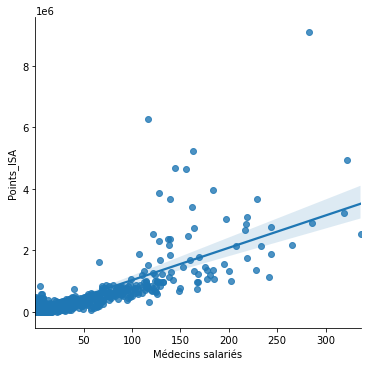

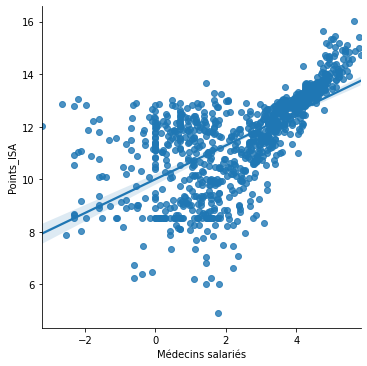

In [54]:


#Pour les médecins salariés, on enlève les valeurs nulles (transformé en log, ce sont les -infini que l'on a recodé en -3) 
# sinon elles baissent artificiellement la droite de régression et rend les graphes moins lisibles

index_null = df[ df['Médecins salariés'] == 0 ].index
index_null_log = df_log[ df_log['Médecins salariés'] == -3 ].index

df_nnull = df.drop(index_null)
df_log_nnull = df_log.drop(index_null_log)

sns.lmplot(x = 'Médecins salariés', y = 'Points_ISA', data = df_nnull)
sns.lmplot(x = 'Médecins salariés', y = 'Points_ISA', data = df_log_nnull)


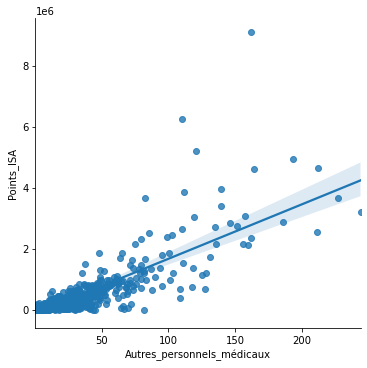

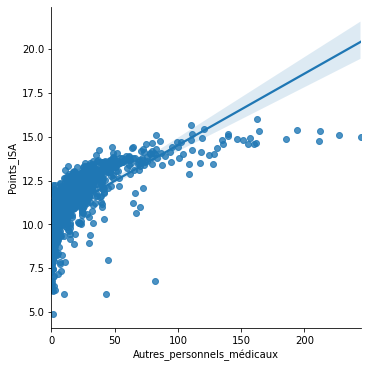

In [63]:
sns.lmplot(x = 'Autres_personnels_médicaux', y = 'Points_ISA', data = df)
sns.lmplot(x = 'Autres_personnels_médicaux', y = 'Points_ISA', data = df_log)

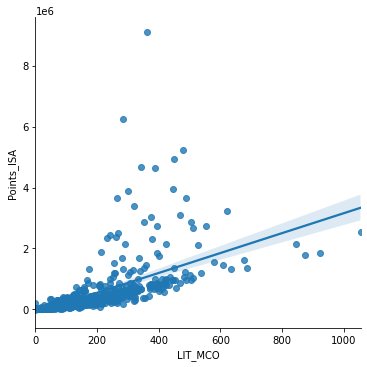

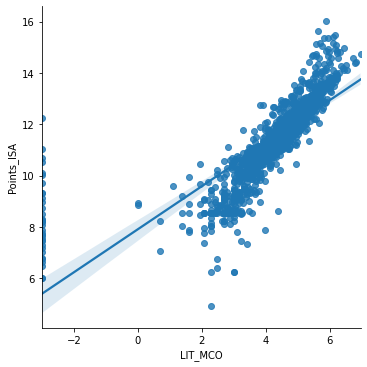

In [55]:
sns.lmplot(x = 'LIT_MCO', y = 'Points_ISA', data = df)
sns.lmplot(x = 'LIT_MCO', y = 'Points_ISA', data = df_log)

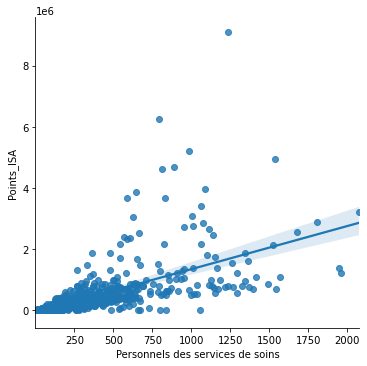

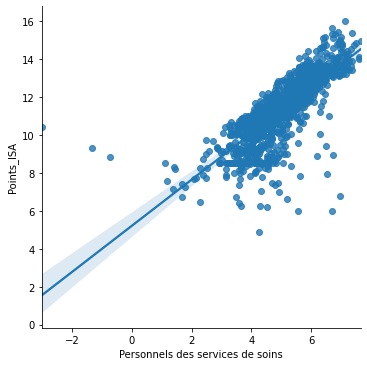

In [56]:
sns.lmplot(x = 'Personnels des services de soins', y = 'Points_ISA', data = df)
sns.lmplot(x = 'Personnels des services de soins', y = 'Points_ISA', data = df_log)

Ces représentations graphiques et régressions montrent bien la pertinence du modèle translog puisque nos variables sont bien plus corrélées log-linéairement que linéairement. 

### 2.2 Comparaison entre un modèle de type Cobb-Douglas et un modèle translog

#### Premiers résultats généraux : 

In [64]:
X = dfm[['Médecins', 'Personnels de direction et administratifs',
       'Personnels des services de soins', 'Personnels éducatifs et sociaux',
       'Personnels médico-techniques', 'Personnels techniques et ouvriers', 'Internes', 'Autres_personnels_médicaux', 
        'LIT_MCO', 'Capital_imagerie', 'Capital_Bloc', 'Capital_Examens_biologiques']]
X = sm.add_constant(X) # on ajoute une constante, sinon la régression se fait sans, par défaut
y = dfm['Points_ISA']

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())



                            OLS Regression Results                            
Dep. Variable:             Points_ISA   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     669.1
Date:                Tue, 11 May 2021   Prob (F-statistic):               0.00
Time:                        15:34:23   Log-Likelihood:                -1082.8
No. Observations:                1155   AIC:                             2192.
Df Residuals:                    1142   BIC:                             2257.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

On obtient des coefficients en grande majorité significatifs à 5%, on peut donc les interpréter. 

In [129]:
X = dfm[['stjr','Médecins', 'Personnels de direction et administratifs',
       'Personnels des services de soins', 'Personnels éducatifs et sociaux',
       'Personnels médico-techniques', 'Personnels techniques et ouvriers', 'Internes', 'Autres_personnels_médicaux',
        'LIT_MCO', 'Capital_tech', 
        'Capital_tech x Autres_personnels_médicaux', 'LIT_MCO x Capital_tech',
       'LIT_MCO x Internes', 'LIT_MCO x Autres_personnels_médicaux',
       'Internes x Capital_tech', 'Internes x Autres_personnels_médicaux',
       'Personnels techniques et ouvriers x Capital_tech',
       'Personnels techniques et ouvriers x LIT_MCO',
       'Personnels techniques et ouvriers x Internes',
       'Personnels techniques et ouvriers x Personnels médico-techniques',
       'Personnels techniques et ouvriers x Personnels des services de soins',
       'Personnels techniques et ouvriers x Personnels de direction et administratifs',
       'Personnels techniques et ouvriers x Autres_personnels_médicaux',
       'Personnels techniques et ouvriers x Médecins',
       'Personnels médico-techniques x Capital_tech',
       'Personnels médico-techniques x LIT_MCO',
       'Personnels médico-techniques x Internes',
       'Personnels médico-techniques x Personnels des services de soins',
       'Personnels médico-techniques x Personnels de direction et administratifs',
       'Personnels médico-techniques x Autres_personnels_médicaux',
       'Personnels médico-techniques x Médecins',
       'Personnels éducatifs et sociaux x Capital_tech',
       'Personnels éducatifs et sociaux x LIT_MCO',
       'Personnels éducatifs et sociaux x Internes',
       'Personnels éducatifs et sociaux x Personnels techniques et ouvriers',
       'Personnels éducatifs et sociaux x Personnels médico-techniques',
       'Personnels éducatifs et sociaux x Personnels des services de soins',
       'Personnels éducatifs et sociaux x Personnels de direction et administratifs',
       'Personnels éducatifs et sociaux x Autres_personnels_médicaux',
       'Personnels éducatifs et sociaux x Médecins',
       'Personnels des services de soins x Capital_tech',
       'Personnels des services de soins x LIT_MCO',
       'Personnels des services de soins x Internes',
       'Personnels des services de soins x Personnels de direction et administratifs',
       'Personnels des services de soins x Autres_personnels_médicaux',
       'Personnels des services de soins x Médecins',
       'Personnels de direction et administratifs x Capital_tech',
       'Personnels de direction et administratifs x LIT_MCO',
       'Personnels de direction et administratifs x Internes',
       'Personnels de direction et administratifs x Autres_personnels_médicaux',
       'Personnels de direction et administratifs x Médecins',
       'Médecins x Capital_tech', 'Médecins x LIT_MCO', 'Médecins x Internes',
       'Médecins x Autres_personnels_médicaux',
        'Capital_tech x Capital_tech', 'Internes x Internes','LIT_MCO x LIT_MCO',
        'Médecins x Médecins', 'Personnels de direction et administratifs x Personnels de direction et administratifs',
        'Personnels des services de soins x Personnels des services de soins',
        'Personnels éducatifs et sociaux x Personnels éducatifs et sociaux', 
        'Personnels médico-techniques x Personnels médico-techniques',
        'Personnels techniques et ouvriers x Personnels techniques et ouvriers', 
        'Autres_personnels_médicaux x Autres_personnels_médicaux']]
X = sm.add_constant(X) # on ajoute une constante, sinon la régression se fait sans, par défaut
y = dfm['Points_ISA']

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())
#results.params[1]

                            OLS Regression Results                            
Dep. Variable:             Points_ISA   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     179.6
Date:                Sun, 09 May 2021   Prob (F-statistic):               0.00
Time:                        19:50:06   Log-Likelihood:                -856.01
No. Observations:                1155   AIC:                             1846.
Df Residuals:                    1088   BIC:                             2184.
Df Model:                          66                                         
Covariance Type:            nonrobust                                         
                                                                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

On constate qu'avec autant de variables, le modèle translog n'est pas pertinent, les p-values élevées montrent que beaucoup de coefficients ne sont pas significatifs. On garde donc pour le moment le modèle simple.
On souhaite à présent comparer ces variables entre les hôpitaux privés, publics et privés à but non lucratif. 

In [65]:
# 1 public 2 privé lucratif 3 privé non lucratif

index_non_public = dfm[ dfm['stjr'] != 1].index
index_non_privé = dfm[ dfm['stjr'] != 2].index
index_non_pnl = dfm[ dfm['stjr'] != 3].index

dfm_public = dfm.drop(index_non_public)
dfm_privé = dfm.drop(index_non_privé)
dfm_pnl = dfm.drop(index_non_pnl)

In [70]:
print("Nombre d'hôpitaux publics : ", dfm_public['stjr'].count())
print("Nombre d'hôpitaux privés : ", dfm_privé['stjr'].count())
print("Nombre d'hôpitaux privés à but non lucratif : ", dfm_pnl['stjr'].count())

Nombre d'hôpitaux publics :  518
Nombre d'hôpitaux privés :  464
Nombre d'hôpitaux privés à but non lucratif :  173


In [75]:
# Régression sur les hôpitaux publics : 

X = dfm_public[['Personnels de direction et administratifs',
       'Personnels des services de soins', 'Personnels éducatifs et sociaux',
       'Personnels médico-techniques', 'Personnels techniques et ouvriers', 'Internes', 'Autres_personnels_médicaux', 
        'LIT_MCO', 'Capital_imagerie', 'Capital_Bloc', 'Capital_Examens_biologiques']]
X = sm.add_constant(X) # on ajoute une constante, sinon la régression se fait sans, par défaut
y = dfm_public['Points_ISA']

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             Points_ISA   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                     617.3
Date:                Tue, 11 May 2021   Prob (F-statistic):          5.77e-285
Time:                        16:08:13   Log-Likelihood:                -411.85
No. Observations:                 518   AIC:                             847.7
Df Residuals:                     506   BIC:                             898.7
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [78]:
# Régression sur les hôpitaux privés

X = dfm_privé[['Médecins', 'Personnels de direction et administratifs',
       'Personnels des services de soins', 'Personnels éducatifs et sociaux',
       'Personnels médico-techniques', 'Personnels techniques et ouvriers', 'Internes', 'Autres_personnels_médicaux', 
        'LIT_MCO', 'Capital_imagerie', 'Capital_Bloc', 'Capital_Examens_biologiques']]
X = sm.add_constant(X) # on ajoute une constante, sinon la régression se fait sans, par défaut
y = dfm_privé['Points_ISA']

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             Points_ISA   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     170.2
Date:                Tue, 11 May 2021   Prob (F-statistic):          6.50e-159
Time:                        16:10:00   Log-Likelihood:                -363.61
No. Observations:                 464   AIC:                             753.2
Df Residuals:                     451   BIC:                             807.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [77]:
# Régression sur les hôpitaux privés à but non lucratif

X = dfm_pnl[['Médecins', 'Personnels de direction et administratifs',
       'Personnels des services de soins', 'Personnels éducatifs et sociaux',
       'Personnels médico-techniques', 'Personnels techniques et ouvriers', 'Internes', 'Autres_personnels_médicaux', 
        'LIT_MCO', 'Capital_imagerie', 'Capital_Bloc', 'Capital_Examens_biologiques']]
X = sm.add_constant(X) # on ajoute une constante, sinon la régression se fait sans, par défaut
y = dfm_pnl['Points_ISA']

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             Points_ISA   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     92.48
Date:                Tue, 11 May 2021   Prob (F-statistic):           1.81e-65
Time:                        16:09:10   Log-Likelihood:                -168.04
No. Observations:                 173   AIC:                             362.1
Df Residuals:                     160   BIC:                             403.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

ATTENTION ces régressions ne sont pas très significatives, voir si on peut arranger avec d'autres variables ! 

BROUILLON

In [59]:
dfm.groupby('Bloc_politique').count()

,Capital_tech x Capital_tech,Capital_tech x Autres_personnels_médicaux,LIT_MCO x Capital_tech,LIT_MCO x LIT_MCO,LIT_MCO x Internes,LIT_MCO x Autres_personnels_médicaux,Internes x Capital_tech,Internes x Internes,Internes x Autres_personnels_médicaux,Personnels techniques et ouvriers x Capital_tech,...,Q1_B,Q1_C,Q1_D,Q8_A,Q8_B,Q8_C,Q8_D,Capital_tech,Médecins,Autres_personnels_médicaux
Bloc_politique,,,,,,,,,,,,,,,,,,,,,
Centre droit à droite,145,145,145,145,145,145,145,145,145,145,...,145,145,145,145,145,145,145,145,145,145
Centre gauche à centre droit,550,550,550,550,550,550,550,550,550,550,...,550,550,550,550,550,550,550,550,550,550
Droite à extrême droite,286,286,286,286,286,286,286,286,286,286,...,286,286,286,286,286,286,286,286,286,286
Extrême gauche à gauche,174,174,174,174,174,174,174,174,174,174,...,174,174,174,174,174,174,174,174,174,174


In [61]:
dfm.groupby('Bloc_politique').count()
index_g = dfm[ dfm['Bloc_politique'] == 'Droite à extrême droite'].index
index_g_bis = dfm[ dfm['Bloc_politique'] == 'Centre droit à droite'].index

dfm_gauche = dfm.drop(index_g)
dfm_g = dfm_gauche.drop(index_g_bis)

In [62]:
X = dfm_g[['Personnels des services de soins', 'Personnels de direction et administratifs',
        'LIT_MCO', 'Capital_Bloc', 'Capital_Examens_biologiques', 'Taux_chomage_par_dep']]
X = sm.add_constant(X) # on ajoute une constante, sinon la régression se fait sans, par défaut
y = dfm_g['Personnels médico-techniques']

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())
results.params

                                 OLS Regression Results                                 
Dep. Variable:     Personnels médico-techniques   R-squared:                       0.702
Model:                                      OLS   Adj. R-squared:                  0.700
Method:                           Least Squares   F-statistic:                     281.8
Date:                          Tue, 11 May 2021   Prob (F-statistic):          8.04e-185
Time:                                  15:30:54   Log-Likelihood:                -1083.4
No. Observations:                           724   AIC:                             2181.
Df Residuals:                               717   BIC:                             2213.
Df Model:                                     6                                         
Covariance Type:                      nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]


const                                       -3.356709
Personnels des services de soins             0.534535
Personnels de direction et administratifs    0.590766
LIT_MCO                                      0.101897
Capital_Bloc                                 0.024187
Capital_Examens_biologiques                  0.059394
Taux_chomage_par_dep                        -0.008047
dtype: float64

In [130]:
X = dfm[['stjr','Médecins', 'Personnels de direction et administratifs',
       'Personnels des services de soins',
        'LIT_MCO', 'Capital_tech',
         'LIT_MCO x Capital_tech',
       'Personnels des services de soins x Capital_tech',
       'Personnels des services de soins x LIT_MCO',
       'Personnels des services de soins x Personnels de direction et administratifs',
       'Personnels des services de soins x Médecins',
       'Personnels de direction et administratifs x Capital_tech',
       'Personnels de direction et administratifs x LIT_MCO',
       'Personnels de direction et administratifs x Médecins',
       'Médecins x Capital_tech', 'Médecins x LIT_MCO',
        'Capital_tech x Capital_tech', 'LIT_MCO x LIT_MCO',
        'Médecins x Médecins', 'Personnels de direction et administratifs x Personnels de direction et administratifs',
        'Personnels des services de soins x Personnels des services de soins']]

X = sm.add_constant(X) # on ajoute une constante, sinon la régression se fait sans, par défaut
y = dfm['Points_ISA']

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:             Points_ISA   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     423.9
Date:                Sun, 09 May 2021   Prob (F-statistic):               0.00
Time:                        19:58:49   Log-Likelihood:                -1026.2
No. Observations:                1155   AIC:                             2096.
Df Residuals:                    1133   BIC:                             2208.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                                                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------